# 1) EXACT REPLICATION:

This script reconstructs Figure 9 from the Sikora 2005 paper.
It uses Ca at 2 debths.

In [1]:
# File: scripts/ganglion_cell.py
# Requires: nrnivmodl-compiled MODs: cas.mod, cad.mod, tsbp.mod, spike.mod, ribbon_tiger.mod

from neuron import h
import os
import numpy as np
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [2]:
# ----------------------------
# Load base HOC/NRN model files
# ----------------------------
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")
h.load_file('stdrun.hoc') 
h.load_file("nrn/cells/gc.nrn")            # defines soma, dend1[], dend2[], dend3[], dend4[], dend5[], dend6[]

1.0

In [3]:
NumSites = 10  # from mod file
GMAX  = 0.00256
GMAXN = 0.00011
ABSR  = 0.0

In [4]:
# ----------------------------
# Create sections used here
# ----------------------------
initseg = h.Section(name='initseg')
narrowr = h.Section(name='narrowr')
axon    = h.Section(name='axon')
preSyn  = h.Section(name='preSyn')
preSyn2 = h.Section(name='preSyn2')


In [5]:
# ----------------------------
# Geometry
# ----------------------------
initseg.nseg = int(45/15); initseg.L = 45; initseg.diam = 1
narrowr.nseg = int(90/15); narrowr.L = 90; narrowr.diam = 0.4
axon.nseg    = int(1000/15); axon.L = 1000; axon.diam = 1

# Connections (soma provided by gc.nrn)
initseg.connect(h.soma(1), 0)   # connect soma(1) -> initseg(0)
narrowr.connect(initseg(1), 0)  # initseg(1) -> narrowr(0)
axon.connect(narrowr(1), 0)     # narrowr(1) -> axon(0)

axon

In [6]:
# TODO: Check what happens if I use my own Calcium mechanisms

In [7]:
# ----------------------------
# Insert global calcium mechanism 'cas' everywhere 
# ----------------------------
for sec in h.allsec():
    sec.insert('cas')
    try:
        sec.taur_cas = 1.5
    except Exception:
        pass  # only sections with cas expose taur_cas


# ----------------------------
# Presynaptic compartments (bipolar cell terminals)
# ----------------------------
# preSyn
preSyn.insert('tsbp')
try:
    preSyn.uninsert('cas')  # ensure no cas in presynaptic compartments
except Exception:
    pass
preSyn.insert('cad')
preSyn.L = 10
preSyn.diam = 10
preSyn.depth_cad = 0.025
preSyn.taur_cad  = 0.1
preSyn.gcabar_tsbp = 0.0012
bpclamp = h.VClamp(preSyn(0.5))
bpclamp.dur[0] = 5500

# preSyn2 (deeper Ca shell)
preSyn2.insert('tsbp')
try:
    preSyn2.uninsert('cas')
except Exception:
    pass
preSyn2.insert('cad')
preSyn2.L = 10
preSyn2.diam = 10
preSyn2.depth_cad = 0.05
preSyn2.taur_cad  = 0.18
preSyn2.gcabar_tsbp = 0.0012
bpclamp2 = h.VClamp(preSyn2(0.5))
bpclamp2.dur[0] = 5500

In [ ]:
# ----------------------------
# Read clamp waveform file and play into both VClamps
# ----------------------------
# WHY: Keep file IO and Vector.play identical to HOC for bitwise parity.
vec = h.Vector()
f = h.File()
if not f.ropen("bp_Sikora.dat"):
    h('printf("WARNING: cannot open bp.dat; clamps will have zero amplitude.\\n")')
    vec = h.Vector(0)
else:
    # scanf(format) identical to HOC: read up to 192000 numbers
    vec.scanf(f, 192000, 1, 1)
    f.close()
vec2 = vec.c()

# dt for play: 0.025 ms
vec.play(bpclamp._ref_amp[0], 0.025)
vec2.play(bpclamp2._ref_amp[0], 0.025)

Vector[1]

In [9]:
# TODO: find other way to produce spike

In [10]:
# ----------------------------
# Spike mechanisms (dendritic/axonal conductances)
# ----------------------------
for sec in h.allsec():
    sec.insert('spike')
    # defaults (dendrites)
    try:
        sec.gcabar_spike = 0.002
        sec.gkbar_spike  = 0.012
        sec.gabar_spike  = 0.036
        sec.gkcbar_spike = 0.000001
        sec.gnabar_spike = 0.025
    except Exception:
        pass

# soma overrides
h.soma.insert('spike')
h.soma.gcabar_spike = 0.0015
h.soma.gkbar_spike  = 0.018
h.soma.gabar_spike  = 0.054
h.soma.gkcbar_spike = 0.000065
h.soma.gnabar_spike = 0.10


# initseg overrides
initseg.insert('spike')
initseg.gcabar_spike = 0.0015
initseg.gkbar_spike  = 0.018
initseg.gabar_spike  = 0.054
initseg.gkcbar_spike = 0.000065
initseg.gnabar_spike = 0.125

# narrowr overrides
narrowr.insert('spike')
narrowr.gcabar_spike = 0.0
narrowr.gkbar_spike  = 0.018
narrowr.gabar_spike  = 0.054
narrowr.gkcbar_spike = 0.000065
narrowr.gnabar_spike = 0.1

# axon overrides
axon.insert('spike')
axon.gcabar_spike = 0.0
axon.gkbar_spike  = 0.018
axon.gabar_spike  = 0.0
axon.gkcbar_spike = 0.000065
axon.gnabar_spike = 0.07


In [11]:
# ----------------------------
# Reversals, passive, axial resistivity
# ----------------------------
for sec in h.allsec():
    # set mechanism variable per segment
    for seg in sec:
        try:
            seg.mod_modulator_spike = 0
        except AttributeError:
            pass  # section may not have the spike mechanism

    sec.ena = 35
    sec.ek  = -75
    sec.cao = 1.8
    sec.cai = 0.0001

    sec.insert('pas')
    sec.g_pas = 1/70000.0
    sec.Ra = 110
    sec.e_pas = -65


# Remove spike channels from presynaptic terminals (as in HOC)
try:
    preSyn.uninsert('spike')
except Exception:
    pass
try:
    preSyn2.uninsert('spike')
except Exception:
    pass

In [12]:
# TODO: try only one debth

In [13]:
# ----------------------------
# Synapses: ribbon_tiger instances and setpointers
# ----------------------------
def make_syn_at(sec, idx):
    """Create a ribbon_tiger at sec(0.5) with Ca pointers hooked up."""
    syn = h.ribbon_tiger(sec(0.5))
    # WHY: setpointer requires Python _ref to map POINTER variables.
    h.setpointer(preSyn(0.5).ca_ion._ref_cai,  'preCA1', syn)
    h.setpointer(preSyn2(0.5).ca_ion._ref_cai, 'preCA2', syn)
    syn.gmax  = 0.00128
    syn.gmaxN = 0.0001
    syn.mg    = 0.5
    return syn

synapse  = [None]*23
synapse2 = [None]*23
synapse3 = [None]*23

# First 12 on dend1[0..11]
for i in range(12):
    sec = h.dend1[i]
    synapse[i]  = make_syn_at(sec, i)
    synapse2[i] = make_syn_at(sec, i)
    synapse3[i] = make_syn_at(sec, i)

# Explicit placements matching HOC
placements = [
    (synapse, 12, h.dend1[19]),
    (synapse, 13, h.dend2[0]),
    (synapse, 14, h.dend2[1]),
    (synapse, 15, h.dend2[10]),
    (synapse, 16, h.dend3[0]),
    (synapse, 17, h.dend1[22]),
    (synapse, 18, h.dend4[0]),
    (synapse, 19, h.dend5[0]),
    (synapse, 20, h.dend6[0]),
    (synapse, 21, h.dend6[1]),
    (synapse, 22, h.dend6[2]),

    (synapse2, 12, h.dend1[19]),
    (synapse2, 13, h.dend2[0]),
    (synapse2, 14, h.dend2[1]),
    (synapse2, 15, h.dend2[10]),
    (synapse2, 16, h.dend3[0]),
    (synapse2, 17, h.dend1[22]),
    (synapse2, 18, h.dend4[0]),
    (synapse2, 19, h.dend5[0]),
    (synapse2, 20, h.dend6[0]),
    (synapse2, 21, h.dend6[1]),
    (synapse2, 22, h.dend6[2]),

    (synapse3, 12, h.dend1[19]),
    (synapse3, 13, h.dend2[0]),
    (synapse3, 14, h.dend2[1]),
    (synapse3, 15, h.dend2[10]),
    (synapse3, 16, h.dend3[0]),
    (synapse3, 17, h.dend1[22]),
    (synapse3, 18, h.dend4[0]),
    (synapse3, 19, h.dend5[0]),
    (synapse3, 20, h.dend6[0]),
    (synapse3, 21, h.dend6[1]),
    (synapse3, 22, h.dend6[2]),
]

for arr, idx, sec in placements:
    arr[idx] = make_syn_at(sec, idx)

In [14]:
# ----------------------------
# Global synapse controls
# ----------------------------

def set_stim():
    """Propagate global synaptic parameters to all synarrays."""
    for arr in (synapse, synapse2, synapse3):
        for s in arr:
            if s is None: 
                continue
            s.gmax = GMAX
            s.gmaxN = GMAXN
            s.AbsRefract = ABSR
            s.mg = 0.5

set_stim()

In [15]:
# ----------------------------
# Recording vectors 
# ----------------------------

# --- Recording vectors ---
t_vec = h.Vector().record(h._ref_t)

# Panel A: bipolar command voltage
v_bipolar_cmd = h.Vector().record(bpclamp._ref_amp[0])

# Panel B: calcium at two depths
ca1_vec = h.Vector().record(preSyn(0.5)._ref_cai)
ca2_vec = h.Vector().record(preSyn2(0.5)._ref_cai)

# Panel C: Orate (total rate)
Orate_vecs = []
for arr in (synapse, synapse2, synapse3):
    for s in arr:
        v = h.Vector().record(s._ref_Orate)
        Orate_vecs.append(v)

# Panel D: record release times by watching release_start[i]
release_event_flags = []

for arr in (synapse, synapse2, synapse3):
    for s in arr:
        for i in range(NumSites):
            v = h.Vector().record(s._ref_release_start[i])
            release_event_flags.append(v)


# Panel F: soma voltage
v_soma = h.Vector().record(h.soma(0.5)._ref_v)

# Panel E: synaptic currents (sum of AMPA + NMDA from all ribbon synapses)
I_syn_vecs = []

for arr in (synapse, synapse2, synapse3):
    for s in arr:
        if s is None: 
            continue
        v = h.Vector().record(s._ref_i)
        I_syn_vecs.append(v)

# ----------------------------
# Run simulation
# ----------------------------
h.dt = 0.025 # ms
h.tstop = 5500
h.CVode().active(0)
h.finitialize(-65)
h.run()

0.0

In [16]:
# ----------------------------
# Convert to numpy
# ----------------------------
t    = t_vec.as_numpy()
v_cmd = v_bipolar_cmd.as_numpy()
ca1  = ca1_vec.as_numpy()
ca2  = ca2_vec.as_numpy()
v_s  = v_soma.as_numpy()

# Orate average
Orate_np = np.array([v.as_numpy() for v in Orate_vecs])
avg_rate = Orate_np.mean(axis=0) / NumSites

# Release events
event_trains = []
for v in release_event_flags:             # each v is a NEURON Vector
    arr = np.array(v)                     # convert to numpy
    # detect when release_start changes value
    changes = np.where(np.diff(arr) != 0)[0]
    times = arr[changes + 1]              # actual times of release
    event_trains.append(times)

I_syn_np = np.array([v.as_numpy() for v in I_syn_vecs])
EPSC = I_syn_np.sum(axis=0)       # nA
EPSC_pA = EPSC * 1000             # convert to pA


print("t:", t)
print("v_cmd:", v_cmd)
print("ca1:", ca1)
print("ca2:", ca2)
#print("epsc:", epsc)
print("v_s:", v_s)

t: [0.000000e+00 2.500000e-02 5.000000e-02 ... 5.499950e+03 5.499975e+03
 5.500000e+03]
v_cmd: [-47.4609375  -47.4609375  -47.4609375  ... -49.75585938 -49.75585938
 -49.75585938]
ca1: [0.0001     0.0001     0.00011609 ... 0.00025856 0.00025856 0.00025856]
ca2: [0.0001     0.0001     0.00010849 ... 0.00024337 0.00024337 0.00024337]
v_s: [-65.         -65.00134529 -65.00643232 ... -63.0755167  -63.0755167
 -63.0755167 ]


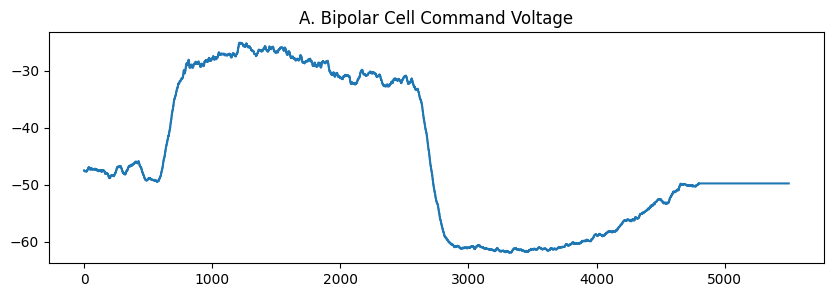

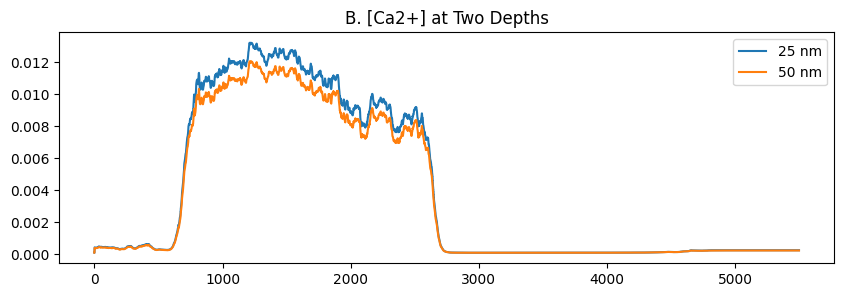

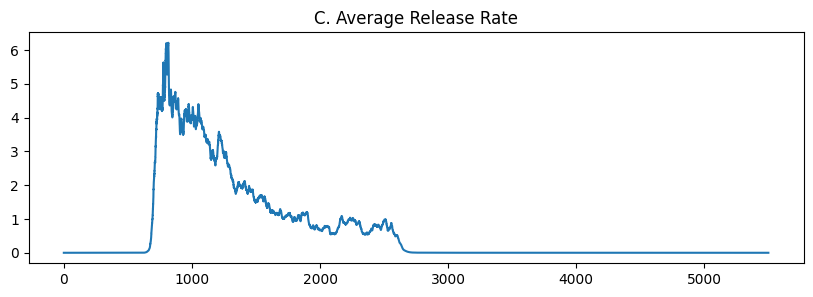

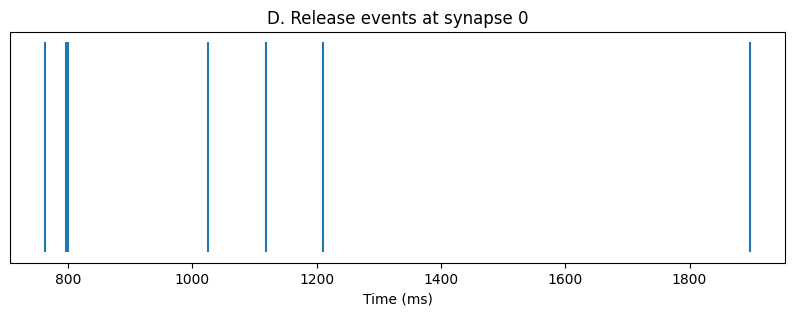

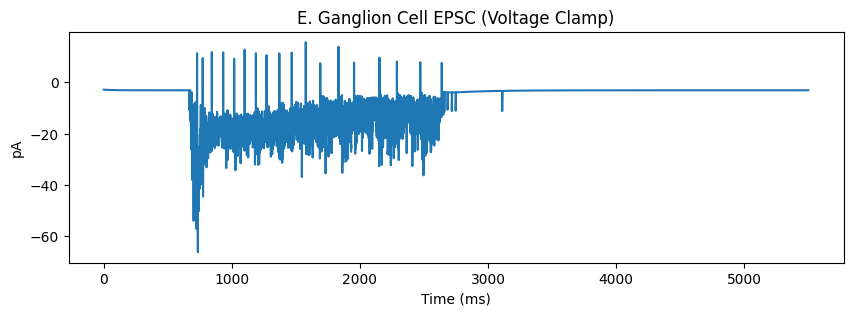

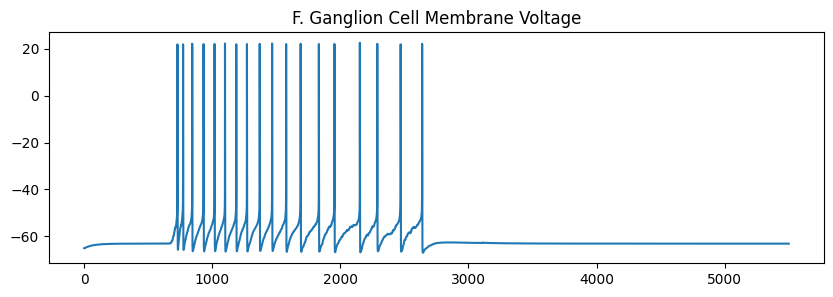

In [17]:
# ----------------------------
# Plot
# ----------------------------
# A — command voltage
plt.figure(figsize=(10, 3))
plt.plot(t, v_cmd)
plt.title("A. Bipolar Cell Command Voltage")
plt.show()

# B — Ca2+ depth
plt.figure(figsize=(10, 3))
plt.plot(t, ca1, label="25 nm")
plt.plot(t, ca2, label="50 nm")
plt.legend()
plt.title("B. [Ca2+] at Two Depths")
plt.show()


# C — avg release rate
plt.figure(figsize=(10, 3))
plt.plot(t, avg_rate)
plt.title("C. Average Release Rate")
plt.show()

#D — raster of release events
k = 0
plt.figure(figsize=(10, 3))
plt.vlines(event_trains[k], 0, 1)
plt.yticks([])
plt.title(f"D. Release events at synapse {k}")
plt.xlabel("Time (ms)")
plt.show()

# E — EPSC under voltage clamp
plt.figure(figsize=(10, 3))
plt.plot(t, EPSC_pA)
plt.title("E. Ganglion Cell EPSC (Voltage Clamp)")
plt.ylabel("pA")
plt.xlabel("Time (ms)")
plt.show()

# F — soma Vm
plt.figure(figsize=(10, 3))
plt.plot(t, v_s)
plt.title("F. Ganglion Cell Membrane Voltage")
plt.show()